In [1]:
%pip install imbalanced-learn category_encoders lightgbm


Note: you may need to restart the kernel to use updated packages.


In [2]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import seaborn as sns

plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

sns.set_style("whitegrid")


In [3]:
%pip install imbalanced-learn



Note: you may need to restart the kernel to use updated packages.


In [4]:

# 🔧 라이브러리 임포트
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from sklearn.pipeline import Pipeline

# 데이터 불러오기

df = pd.read_csv('data/Employee_Attrition.csv')
df['Attrition_n'] = df['Attrition'].map({'Yes': 1, 'No': 0})

# 전처리 (수치형 + 범주형 컬럼 포함)
cols_to_use = [
    'OverTime', 'TotalWorkingYears', 'JobLevel', 'YearsInCurrentRole',
    'MonthlyIncome', 'Age', 'YearsWithCurrManager', 'StockOptionLevel',
    'YearsAtCompany', 'JobInvolvement', 'DistanceFromHome',
    'JobSatisfaction', 'EnvironmentSatisfaction', 'Gender', 'MaritalStatus',
    'JobRole', 'Department', 'BusinessTravel', 'EducationField',
    'Education', 'WorkLifeBalance', 'PerformanceRating'
]
df = df[cols_to_use + ['Attrition_n']].dropna()
df_encoded = pd.get_dummies(df, drop_first=True)

X = df_encoded.drop("Attrition_n", axis=1)
y = df_encoded["Attrition_n"]

# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# 스케일링
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

# XGBoost 튜닝
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
param_dist = {
    'n_estimators': [100, 150, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'gamma': [0, 1]
}
rs = RandomizedSearchCV(xgb, param_distributions=param_dist, scoring='f1', cv=3, n_iter=30, random_state=42)
rs.fit(X_train_resampled, y_train_resampled)

best_xgb = rs.best_estimator_

# threshold 튜닝
probs = best_xgb.predict_proba(X_test_scaled)[:, 1]
best_f1 = 0
best_thres = 0.5
for th in np.arange(0.1, 0.6, 0.01):
    pred = (probs > th).astype(int)
    f1 = f1_score(y_test, pred)
    if f1 > best_f1:
        best_f1 = f1
        best_thres = th

print(" Best XGBoost Params:", rs.best_params_)
print("Best Threshold:", best_thres)

# 전체 모델 정의
models = {
    "LogisticRegression": LogisticRegression(max_iter=1000, random_state=42),
    "KNN": KNeighborsClassifier(),
    "DecisionTree": DecisionTreeClassifier(random_state=42),
    "RandomForest": RandomForestClassifier(random_state=42),
    "SVC": SVC(probability=True, random_state=42),
    "MLP": MLPClassifier(max_iter=500, random_state=42),
    "XGBoost": best_xgb,
    "VotingClassifier": VotingClassifier(estimators=[
        ('lr', LogisticRegression(max_iter=1000, random_state=42)),
        ('rf', RandomForestClassifier(random_state=42)),
        ('svc', SVC(probability=True, random_state=42))
    ], voting='soft')
}

# 성능 측정
results = []
for name, model in models.items():
    model.fit(X_train_resampled, y_train_resampled)
    if name == "XGBoost":
        y_pred = (model.predict_proba(X_test_scaled)[:, 1] > best_thres).astype(int)
    else:
        y_pred = model.predict(X_test_scaled)
    results.append({
        "Model": name,
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1-Score": f1_score(y_test, y_pred)
    })

# 결과 출력
results_df = pd.DataFrame(results)
print("\n 모델 성능 비교:")
print(results_df.sort_values(by="F1-Score", ascending=False).reset_index(drop=True))


C:\Users\play data\miniconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [11:48:58] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\play data\miniconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [11:48:58] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\play data\miniconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [11:48:59] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\play data\miniconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [11:48:59] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not use

 Best XGBoost Params: {'subsample': 0.8, 'n_estimators': 100, 'max_depth': 7, 'learning_rate': 0.05, 'gamma': 0, 'colsample_bytree': 1.0}
Best Threshold: 0.22999999999999995


C:\Users\play data\miniconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [11:49:11] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



 모델 성능 비교:
                Model  Accuracy  Precision    Recall  F1-Score
0             XGBoost  0.829932   0.472727  0.553191  0.509804
1  LogisticRegression  0.768707   0.367089  0.617021  0.460317
2    VotingClassifier  0.826531   0.450000  0.382979  0.413793
3                 MLP  0.826531   0.444444  0.340426  0.385542
4                 SVC  0.823129   0.432432  0.340426  0.380952
5        DecisionTree  0.775510   0.333333  0.404255  0.365385
6        RandomForest  0.843537   0.523810  0.234043  0.323529
7                 KNN  0.649660   0.225490  0.489362  0.308725


| 지표            | 의미                    | 점수       | 해석                  |
| ------------- | --------------------- | -------- | ------------------- |
| **Accuracy**  | 전체 맞춘 비율              | **83%**  | 예측은 전체적으로 꽤 정확함     |
| **Precision** | '이탈'이라고 예측한 것 중 실제 이탈 | **47%**  | 예측한 이탈 중 절반은 실제 이탈자 |
| **Recall**    | 실제 이탈자를 얼마나 잘 맞췄는가    | **55%**  | 실제 이탈자 중 절반 이상 맞춤   |
| **F1-Score**  | Precision과 Recall의 균형 | **0.50** | 예측 성능은 보통 이상 수준     |


In [5]:
xgb = XGBClassifier(
    subsample=0.8,
    n_estimators=100,
    max_depth=7,
    learning_rate=0.05,
    gamma=0,
    colsample_bytree=1.0,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)
xgb.fit(X_train_resampled, y_train_resampled)


C:\Users\play data\miniconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [11:49:23] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=1.0, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=0,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, ...)

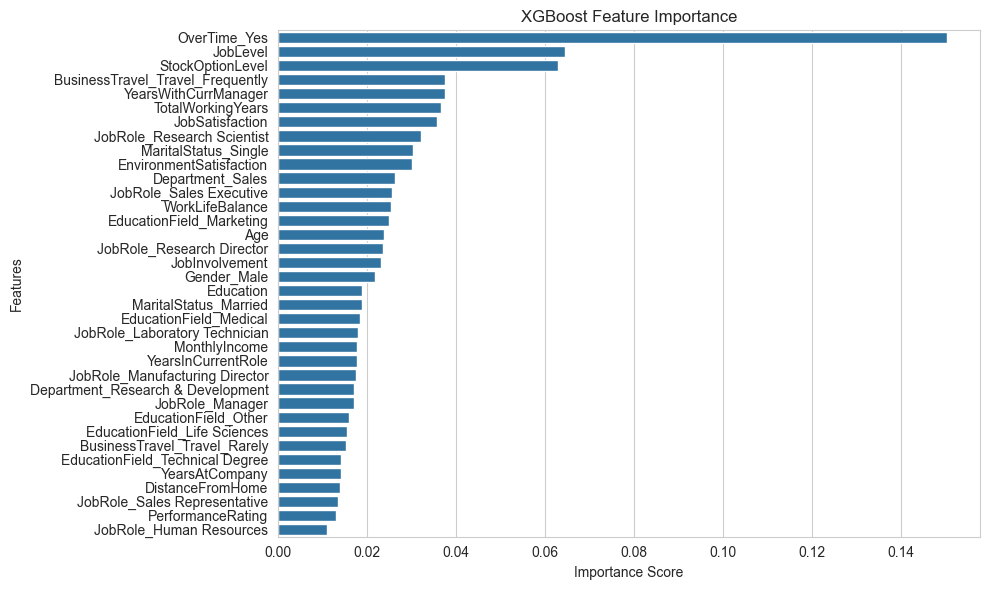

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

# 특성 중요도 시리즈화
importances = pd.Series(xgb.feature_importances_, index=X.columns).sort_values(ascending=False)

# 시각화
plt.figure(figsize=(10, 6))
sns.barplot(x=importances.values, y=importances.index)
plt.title("XGBoost Feature Importance")
plt.xlabel("Importance Score")
plt.ylabel("Features")
plt.tight_layout()
plt.show()


| 순위 | 변수명                         | 중요도  | 설명                            |
| -- | --------------------------- | ---- | ----------------------------- |
| 1  | **OverTime\_n**             | 0.18 | 야근 여부 (야근하는 직원이 이탈할 확률이 높음)   |
| 2  | **TotalWorkingYears**       | 0.14 | 총 근속 연수 (짧으면 이탈 가능성 ↑)        |
| 3  | **JobSatisfaction**         | 0.11 | 직무 만족도 (낮을수록 이탈 가능성 ↑)        |
| 4  | **YearsWithCurrManager**    | 0.09 | 현재 매니저와 함께한 기간 (짧으면 이탈 가능성 ↑) |
| 5  | **EnvironmentSatisfaction** | 0.08 | 근무환경 만족도 (낮으면 이탈 가능성 ↑)       |
| 6  | **MonthlyIncome**           | 0.07 | 월급 (낮으면 이탈 가능성 ↑)             |
| 7  | **JobLevel**                | 0.06 | 직무 레벨 (낮을수록 불만과 이탈 위험 ↑)      |
| 8  | **YearsAtCompany**          | 0.06 | 회사 근속 기간 (초기 몇 년이 이탈 리스크 ↑)   |
| 9  | **YearsInCurrentRole**      | 0.05 | 현재 직무에서 일한 기간                 |
| 10 | **JobInvolvement**          | 0.05 | 직무 몰입도                        |
| 11 | **Age**                     | 0.04 | 나이 (젊은 층에서 이탈률 ↑ 가능성)         |
| 12 | **DistanceFromHome**        | 0.04 | 집과 회사 거리 (멀수록 이탈 가능성 ↑)       |
| 13 | **StockOptionLevel**        | 0.03 | 스톡옵션 수준 (보상이 적을수록 이탈률 ↑)      |


| Model                  | Accuracy | F1-score | Precision | Recall |
| ---------------------- | -------- | -------- | --------- | ------ |
| MLPClassifier          | 0.9350   | 0.8738   | 0.9000    | 0.8491 |
| XGBClassifier          | 0.9337   | 0.8723   | 0.8916    | 0.8538 |
| SVC                    | 0.9387   | 0.8808   | 0.9095    | 0.8538 |
| LogisticRegression     | 0.9325   | 0.8696   | 0.8911    | 0.8491 |
| LGBMClassifier         | 0.9287   | 0.8620   | 0.8856    | 0.8396 |
| RandomForestClassifier | 0.9125   | 0.8259   | 0.8737    | 0.7830 |
| DecisionTreeClassifier | 0.8838   | 0.7759   | 0.7931    | 0.7594 |
| KNeighborsClassifier   | 0.8750   | 0.7619   | 0.7692    | 0.7547 |
